In [1]:
import json
from collections import defaultdict
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import utils
import plot_utils
from tqdm.notebook import tqdm, tqdm_notebook
tqdm_notebook.pandas()


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def load_public_dataset(tournament='World_Cup'):
    """
    Load the json files with the matches, events, players and competitions
    
    Parameters
    ----------
    data_folder : str, optional
        the path to the folder where json files are stored.
        
    tournaments : list, optional
        the list of tournaments to load. 
        
    Returns
    -------
    tuple
        a tuple of four dictionaries, containing matches, events, players and competitions
        
    """
    # loading the matches and events data
    matches, events = {}, {}
    with open('events/events_%s.json' %tournament) as json_data:
        events = json.load(json_data)
    with open('matches/matches_%s.json' %tournament) as json_data:
        matches = json.load(json_data)
    
    match_id2events = defaultdict(list)
    match_id2match = defaultdict(dict)
    for event in events:
        match_id = event['matchId']
        match_id2events[match_id].append(event)
                                         
    for match in matches:
        match_id = match['wyId']
        match_id2match[match_id] = match

    # loading the players data
    with open('players.json') as json_data:
        players = json.load(json_data)
    
    player_id2player = defaultdict(dict)
    for player in players:
        player_id = player['wyId']
        player_id2player[player_id] = player
    
    # loading the competitions data
    teams={}
    with open('teams.json') as json_data:
        teams = json.load(json_data)
    team_id2team = defaultdict(dict)
    for team in teams:
        team_id = team['wyId']
        team_id2team[team_id] = team

    #Corrigindo o nome do time Francês para igualar ao 'events'
    team_id2team[3799]['name'] = 'Angers SCO'
    
    return match_id2match, match_id2events, player_id2player, team_id2team

In [3]:
def passing_networks(match_id=2057954):
    """
    Construct the passing networks of the teams in the match.
    
    Parameters
    ----------
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        the two constructed networks, as networkx objects.
    """
    
    # take the names of the two teams of the match
    match_label = match_id2match[match_id]['label']
    team1_name = match_label.split(' - ')[0].strip()
    team2_name = match_label.split(' - ')[1].split(',')[0].strip()

    # take all the events of the match
    match_events = list(match_id2events[match_id])
    match_events_df = pd.DataFrame(match_events)
    first_half_max_duration = np.max(match_events_df[match_events_df['matchPeriod'] == '1H']['eventSec'])
    # sum 1H time end to all the time in 2H
    for event in match_events:
        if event['matchPeriod'] == '2H':
            event['eventSec'] += first_half_max_duration

    team2pass2weight = defaultdict(lambda: defaultdict(int))
    for event, next_event, next_next_event in zip(match_events, match_events[1:], match_events[2:]):
        try:
            if event['eventName'] == 'Pass' and 1801 in [tag['id'] for tag in event['tags']]:
                sender = player_id2player[event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                # if the next event of from a player of the same team
                if (next_event['teamId'] == event['teamId']) & (next_event['playerId'] != event['playerId']):
                    receiver = player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                    team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                elif (next_next_event['teamId'] == event['teamId']) & (next_next_event['playerId'] != event['playerId']):
                    receiver = player_id2player[next_next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                    team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1  
        except KeyError:
            pass
    # crete networkx graphs
    G1, G2 = nx.DiGraph(team=team1_name), nx.DiGraph(team=team2_name)
    for (sender, receiver), weight in team2pass2weight[team1_name].items():
        G1.add_edge(sender, receiver, weight=weight)
    for (sender, receiver), weight in team2pass2weight[team2_name].items():
        G2.add_edge(sender, receiver, weight=weight)    
    
    return G1, G2

In [4]:
def pith_pos_to_dict(data):

    aux = data[['playerId', 'y', 'x']]
    aux['nome'] = aux['playerId'].apply(lambda p: player_id2player[p]['shortName'].encode('ascii', 'strict').decode('unicode-escape'))

    res = dict(zip(aux['nome'], zip(aux['x'], aux['y'])))

    return res

In [5]:
def plot_passing_networks(G1, G2, df_pos):
    """
    Plot the two passing networks in input.
    
    Parameters
    ----------
    G1 : networkx object
        the object representing the first network
        
    G2 : networkx object
        the object representing the second network
    """
    #TO DO:
    # ***** Plotar nodes e edges baseado no peso *****

    player_pos = pith_pos_to_dict(df_pos)

    fig, ax1 = plot_utils.pitch()
    fig, ax2 = plot_utils.pitch()
    

    nome2degree = dict(G1.degree)
    nx.draw(G1, pos=player_pos ,nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()], 
            node_color='red', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75, ax=ax1)
    ax1.set_title('Time 1')
    ax1.set_xlim([0, 100])
    ax1.set_ylim([0, 100])
    ax1.set_axis_on()

    
    nome2degree = dict(G2.degree)
    nx.draw(G2, pos=player_pos, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()],
            node_color='blue', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75, ax=ax2)
    ax2.set_title('Time 2')
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0, 100])
    ax2.set_axis_on()
    
    plt.figure(figsize=(4, 3))
    plt.show()

In [6]:
#degree_centrality
def degree_centrality(netlist, i):
    data_avg = []
    data_std = []
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.degree_centrality(net[i]).values())))
        data_std.append(np.std(list(nx.degree_centrality(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_degree_centrality_T{i+1}', f'std_degree_centrality_T{i+1}'])


#betwenness_centrality
def betwenness_centrality(netlist, i):
    data_avg = []
    data_std = []
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.betweenness_centrality(net[i]).values())))
        data_std.append(np.std(list(nx.betweenness_centrality(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_betweenness_centrality_T{i+1}', f'std_betweenness_centrality_T{i+1}'])

#closeness_centrality
def closeness_centrality(netlist, i):
    data_avg = []
    data_std = [] 
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.closeness_centrality(net[i]).values())))
        data_std.append(np.std(list(nx.closeness_centrality(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_closeness_centrality_T{i+1}', f'std_closeness_centrality_T{i+1}'])

#eigenvalue_centrality
def eigenvector_centrality(netlist, i):
    data_avg = []
    data_std = []
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.eigenvector_centrality(net[i]).values())))
        data_std.append(np.std(list(nx.eigenvector_centrality(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_eigenvector_centrality_T{i+1}', f'std_eigenvector_centrality_T{i+1}'])

#clustering coefficient
def clustering_coefficient(netlist, i):
    data_avg = []
    data_std = []
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.clustering(net[i]).values())))
        data_std.append(np.std(list(nx.clustering(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_clustering_T{i+1}', f'std_clustering_T{i+1}'])

#average shortest path lenght
def avg_shortest_path(netlist, i):
    data_avg = []
    for net in netlist.values():
        data_avg.append((nx.average_shortest_path_length(net[i])))

    return pd.DataFrame(data_avg, columns=[f'avg_shortest_path_T{i+1}'])

#position centroid
def centroid(netlist, i):
    centroid = pitch_coords.groupby(['matchId', 'teamId']).agg({'y':([np.mean, np.std]), 'x':([np.mean, np.std])}).reset_index()
    centroid.columns = ['matchId', 'teamId', f'mean_centroid_y_T{i+1}', f'std_centroid_y_T{i+1}', f'mean_centroid_x_T{i+1}', f'std_centroid_x_T{i+1}']
    
    return centroid

In [7]:
for tournament in tqdm(utils.TOURNAMENTS, total= len(utils.TOURNAMENTS)):
    print("TOURNAMENT: %s" %tournament)

    # carrega dados
    print("carregando dados")
    match_id2match, match_id2events, player_id2player, team_id2team = load_public_dataset(tournament)
    matches = pd.read_json('matches\matches_%s.json' %tournament)
    events = pd.read_json('events\events_%s.json' %tournament)

    #consertando erros do dataset
    if tournament == 'France':
        matches.loc[1, 'winner'] = 3804
        matches.loc[37, 'winner'] = 3770
    elif tournament == 'Germany':
        matches.loc[48, 'winner'] = 2450
        matches.loc[102, 'winner'] = 2449

    #tira penalidades
    events = events[events['matchPeriod'] != 'P']

    # converte coluna 'tags' par algo manipulável
    print("convertendo tags")
    events['tags'] = events['tags'].map(utils.converting_tags)

    # gera coordenada média de cada node
    print("gerando coordenadas médias")
    passes = events[(events['eventName'] == 'Pass') & (events['tags'].apply(lambda x: (1801 in x)))]

    coords = passes['positions'].apply(pd.Series)[0].apply(pd.Series)
    passes = passes.join(coords)
    passes = passes.drop(['positions'], axis = 1)

    pitch_coords = passes.groupby(['matchId', 'teamId', 'playerId']).agg(y=('y','mean'), x=('x','mean'))
    pitch_coords = pitch_coords.reset_index()

    #gera redes
    print("gerando redes")
    net_list = defaultdict(tuple)
    for matchID in match_id2match.keys():    
        G1, G2 = passing_networks(match_id = matchID)
        par = (G1, G2)
        net_list[matchID] = par


    # - Gera bases -
    print("gerando base")

    # -- HOME --

    dfh = matches[['wyId']]
    dfh = dfh.rename(columns={'wyId':'matchID'})

    home_l = []
    away_l = []

    for match in matches['teamsData']:
        t0 = list(match.values())[0]
        t1 = list(match.values())[1]

        if t0['side'] == 'home':
            home_l.append(t0['teamId'])
            away_l.append(t1['teamId'])  
        else: 
            away_l.append(t0['teamId'])
            home_l.append(t1['teamId'])

    dfh['team1_ID'] = home_l
    dfh['team2_ID'] = away_l

    dfh['date'] = matches['date']

    dfh['tournament'] = tournament

    closeness = closeness_centrality(net_list, 0)
    degree = degree_centrality(net_list, 0)
    betwenness = betwenness_centrality(net_list, 0)
    eigenvector = eigenvector_centrality(net_list, 0)
    clustering = clustering_coefficient(net_list, 0)
    shortest_path = avg_shortest_path(net_list, 0)
    df_centroid = centroid(net_list, 0)

    dfh = dfh.join(closeness)
    dfh = dfh.join(degree)
    dfh = dfh.join(betwenness)
    dfh = dfh.join(eigenvector)
    dfh = dfh.join(clustering)
    dfh = dfh.join(shortest_path)

    dfh = dfh.merge(df_centroid, how='left', left_on=['matchID', 'team1_ID'], right_on=['matchId', 'teamId']).drop(['matchId', 'teamId'], axis=1)


    # -- AWAY --

    dfa = matches[['wyId']]
    dfa = dfa.rename(columns={'wyId':'matchID'})

    dfa['team1_ID'] = home_l
    dfa['team2_ID'] = away_l

    dfa['date'] = matches['date']

    dfa['tournament'] = tournament

    closeness = closeness_centrality(net_list, 1)
    degree = degree_centrality(net_list, 1)
    betwenness = betwenness_centrality(net_list, 1)
    eigenvector = eigenvector_centrality(net_list, 1)
    clustering = clustering_coefficient(net_list, 1)
    shortest_path = avg_shortest_path(net_list, 1)
    df_centroid = centroid(net_list, 1)

    dfa = dfa.join(closeness)
    dfa = dfa.join(degree)
    dfa = dfa.join(betwenness)
    dfa = dfa.join(eigenvector)
    dfa = dfa.join(clustering)
    dfa = dfa.join(shortest_path)

    dfa = dfa.merge(df_centroid, how='left', left_on=['matchID', 'team2_ID'], right_on=['matchId', 'teamId']).drop(['matchId', 'teamId'], axis=1)


    #definindo vencedor e retirando empates apenas do dfh (df home)
    dfh['winner'] = matches['winner']
    dfh = dfh.loc[dfh['winner'] != 0]
    matches = matches.loc[matches['winner'] != 0]
    dfh['winner'] = np.where((matches['winner'] == dfh['team1_ID']), 1, 0)

    print("gerando csv")
    dfh.to_csv('analitics/network_%s_home.csv' %tournament, encoding='utf-8', index=False)
    dfa.to_csv('analitics/network_%s_away.csv' %tournament, encoding='utf-8', index=False)

    # print("plotando uma rede")
    # first_net = next(iter(net_list))
    # plot_passing_networks(net_list[first_net][0], net_list[first_net][1], pitch_coords[pitch_coords['matchId'] == first_net])
    print('-----------------')

  0%|          | 0/7 [00:00<?, ?it/s]

TOURNAMENT: Italy
carregando dados
convertendo tags
gerando coordenadas médias
gerando redes
gerando base
gerando csv
-----------------
TOURNAMENT: England
carregando dados
convertendo tags
gerando coordenadas médias
gerando redes
gerando base
gerando csv
-----------------
TOURNAMENT: Germany
carregando dados
convertendo tags
gerando coordenadas médias
gerando redes
gerando base
gerando csv
-----------------
TOURNAMENT: France
carregando dados
convertendo tags
gerando coordenadas médias
gerando redes
gerando base
gerando csv
-----------------
TOURNAMENT: Spain
carregando dados
convertendo tags
gerando coordenadas médias
gerando redes
gerando base
gerando csv
-----------------
TOURNAMENT: European_Championship
carregando dados
convertendo tags
gerando coordenadas médias
gerando redes
gerando base
gerando csv
-----------------
TOURNAMENT: World_Cup
carregando dados
convertendo tags
gerando coordenadas médias
gerando redes
gerando base
gerando csv
-----------------


C:\Users\eduar\AppData\Local\Temp/ipykernel_22776/2647024513.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



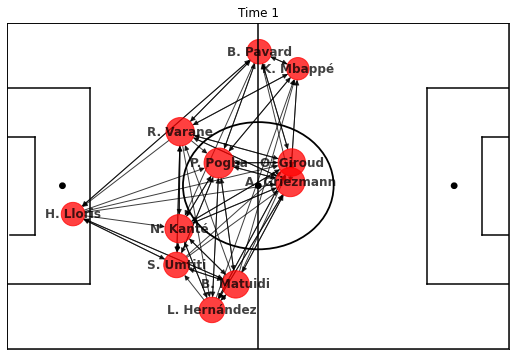

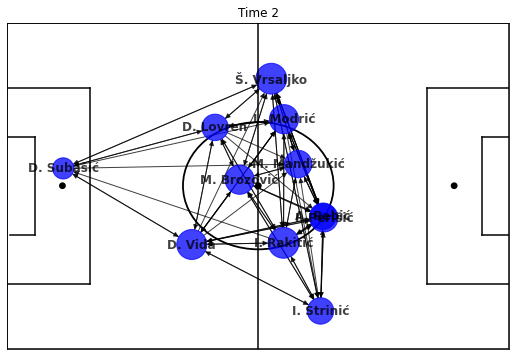

<Figure size 288x216 with 0 Axes>

In [8]:
first_net = next(iter(net_list))
plot_passing_networks(net_list[first_net][0], net_list[first_net][1], pitch_coords[pitch_coords['matchId'] == first_net])
